In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os
from dotenv import load_dotenv
from pathlib import Path

In [2]:
#df_registrations = pd.read_csv('./regs_1k.csv')

In [3]:
#df_visits = pd.read_csv('./visits_1k.csv')

In [4]:
load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

#print(API_URL)
#print(DATE_BEGIN)
#print(DATE_END)

#response = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
registration_json = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")

In [5]:
#url_registrations = "https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01"
#response = requests.get(url_registrations)
#if response.status_code == 200:  
#    data = response.json()
data_reg=registration_json.json()
df_registrations=pd.DataFrame(data_reg)
#df_registrations = pd.DataFrame(data)

In [6]:
df_registrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21836 entries, 0 to 21835
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   datetime           21836 non-null  object
 1   user_id            21836 non-null  object
 2   email              21836 non-null  object
 3   platform           21836 non-null  object
 4   registration_type  21836 non-null  object
dtypes: object(5)
memory usage: 853.1+ KB


In [7]:
#response = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
visit_json = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")

In [8]:
#url_visits = "https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01"
#response = requests.get(url_visits)
#if response.status_code == 200:  
#    data = response.json()
#df_visits = pd.DataFrame(data)
data_vis=visit_json.json() #перевод в JSON
df_visits=pd.DataFrame(data_vis) #перевод JSON в DataFrame

In [9]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263459 entries, 0 to 263458
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   visit_id    263459 non-null  object
 1   platform    263459 non-null  object
 2   user_agent  263459 non-null  object
 3   datetime    263459 non-null  object
dtypes: object(4)
memory usage: 8.0+ MB


In [10]:
df_registrations['datetime'] = pd.to_datetime(df_registrations['datetime'])
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])

Отфильтровываю ботов

In [11]:
human_visits = df_visits[~df_visits['user_agent'].str.contains('bot')]

Сортирую по дате и для каждого visit_id беру последнюю дату

In [12]:
last_visits = human_visits.sort_values('datetime').drop_duplicates('visit_id', keep='last')

Делаю агрегацию регистраций по дате и платформе

In [13]:
df_registrations['date_group'] = df_registrations['datetime'].dt.date
aggregated_registrations = df_registrations.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

In [14]:
aggregated_registrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date_group     552 non-null    object
 1   platform       552 non-null    object
 2   registrations  552 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.1+ KB


Делаю агрегацию визитов по дате и платформе

In [15]:
last_visits['date_group'] = last_visits['datetime'].dt.date
aggregated_visits = last_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')

In [16]:
aggregated_registrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date_group     552 non-null    object
 1   platform       552 non-null    object
 2   registrations  552 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.1+ KB


Далее объединяю и считаю конверсию

In [17]:
merged_data = pd.merge(aggregated_registrations, aggregated_visits, on=['date_group', 'platform'], how='inner')

In [18]:
merged_data["conversion"] = merged_data["registrations"] * 100 / merged_data["visits"]

In [19]:
merged_data = merged_data[["date_group", "platform", "visits", "registrations", "conversion"]]

In [20]:
merged_data_sorted = merged_data.sort_values(by='date_group', ascending=True)

In [21]:
merged_data_sorted.to_json('conversion.json')

Анализ затрат на рекламу

In [22]:
df_ads = pd.read_csv('./ads.csv')

In [23]:
df_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          159 non-null    object
 1   utm_source    159 non-null    object
 2   utm_medium    159 non-null    object
 3   utm_campaign  159 non-null    object
 4   cost          159 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 6.3+ KB


Сортирую по дате и меняю название колонки

In [24]:
df_ads_sorted = df_ads.sort_values(by='date', ascending=True)

In [25]:
df_ads['date_group'] = pd.to_datetime(df_ads['date']).dt.date

Выбираю колонки, с которыми буду дальше работать

In [26]:
temp_ads = df_ads[["date_group", "utm_campaign", "cost"]]

In [27]:
temp_ads.head(10)

,date_group,utm_campaign,cost
0,2023-03-01,advanced_algorithms_series,212
1,2023-03-02,advanced_algorithms_series,252
2,2023-03-03,advanced_algorithms_series,202
3,2023-03-04,advanced_algorithms_series,223
4,2023-03-05,advanced_algorithms_series,265
5,2023-03-06,advanced_algorithms_series,108
6,2023-03-07,advanced_algorithms_series,165
7,2023-03-08,advanced_algorithms_series,155
8,2023-03-09,advanced_algorithms_series,124
9,2023-03-10,advanced_algorithms_series,276


Объединяю их с данными по стоимости рекламных кампаний.

In [28]:
merged_data_sorted.head(10)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
5,2023-03-02,web,515,23,4.466019
6,2023-03-03,android,26,22,84.615385
7,2023-03-03,ios,40,34,85.000000
8,2023-03-03,web,617,51,8.265802
9,2023-03-04,android,94,77,81.914894


In [29]:
merged_df = pd.merge(merged_data_sorted, temp_ads, on='date_group', how='left')

In [30]:
merged_df.head(10)

,date_group,platform,visits,registrations,conversion,utm_campaign,cost
0,2023-03-01,android,75,61,81.333333,advanced_algorithms_series,212.0
1,2023-03-01,ios,22,18,81.818182,advanced_algorithms_series,212.0
2,2023-03-01,web,279,8,2.867384,advanced_algorithms_series,212.0
3,2023-03-02,android,67,59,88.059701,advanced_algorithms_series,252.0
4,2023-03-02,ios,31,24,77.419355,advanced_algorithms_series,252.0
5,2023-03-02,web,515,23,4.466019,advanced_algorithms_series,252.0
6,2023-03-03,android,26,22,84.615385,advanced_algorithms_series,202.0
7,2023-03-03,ios,40,34,85.000000,advanced_algorithms_series,202.0
8,2023-03-03,web,617,51,8.265802,advanced_algorithms_series,202.0
9,2023-03-04,android,94,77,81.914894,advanced_algorithms_series,223.0


In [31]:
merged_df['cost'] = merged_df['cost'].fillna(0)
merged_df['utm_campaign'] = merged_df['utm_campaign'].fillna("none")

Сортирую по дате и останваливаю только нужные столбцы

In [32]:
merged_df_sorted = merged_df.sort_values(by='date_group', ascending=True)

In [33]:
merged_df_sorted = merged_df_sorted[["date_group", "visits", "registrations", "cost", "utm_campaign"]]

In [34]:
merged_df_sorted.head(10)

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212.0,advanced_algorithms_series
1,2023-03-01,22,18,212.0,advanced_algorithms_series
2,2023-03-01,279,8,212.0,advanced_algorithms_series
3,2023-03-02,67,59,252.0,advanced_algorithms_series
4,2023-03-02,31,24,252.0,advanced_algorithms_series
5,2023-03-02,515,23,252.0,advanced_algorithms_series
6,2023-03-03,26,22,202.0,advanced_algorithms_series
7,2023-03-03,40,34,202.0,advanced_algorithms_series
8,2023-03-03,617,51,202.0,advanced_algorithms_series
9,2023-03-04,94,77,223.0,advanced_algorithms_series


In [35]:
merged_df_sorted.to_json('ads.json')

Построение графиков

Проверяем есть ли папка charts, если нет, то создаём её:

In [36]:
#dirpath = "./charts"

#if not os.path.isdir(dirpath):
#    os.mkdir(dirpath)
p = Path.cwd()
d = p / 'charts'
d.mkdir(exist_ok=True)

1. Итоговые визиты

In [37]:
merged_data_sorted['date_group'] = pd.to_datetime(merged_data_sorted['date_group'])

In [38]:
total_visits_by_date = merged_data_sorted.groupby('date_group')['visits'].sum().reset_index()

In [39]:
num_dates = len(total_visits_by_date['date_group'].unique())
scale = num_dates // 60
tick_indices = range(0, num_dates, scale)

dates_str = total_visits_by_date['date_group'].dt.strftime('%Y-%m-%d')
tick_labels = [dates_str[i] for i in tick_indices]

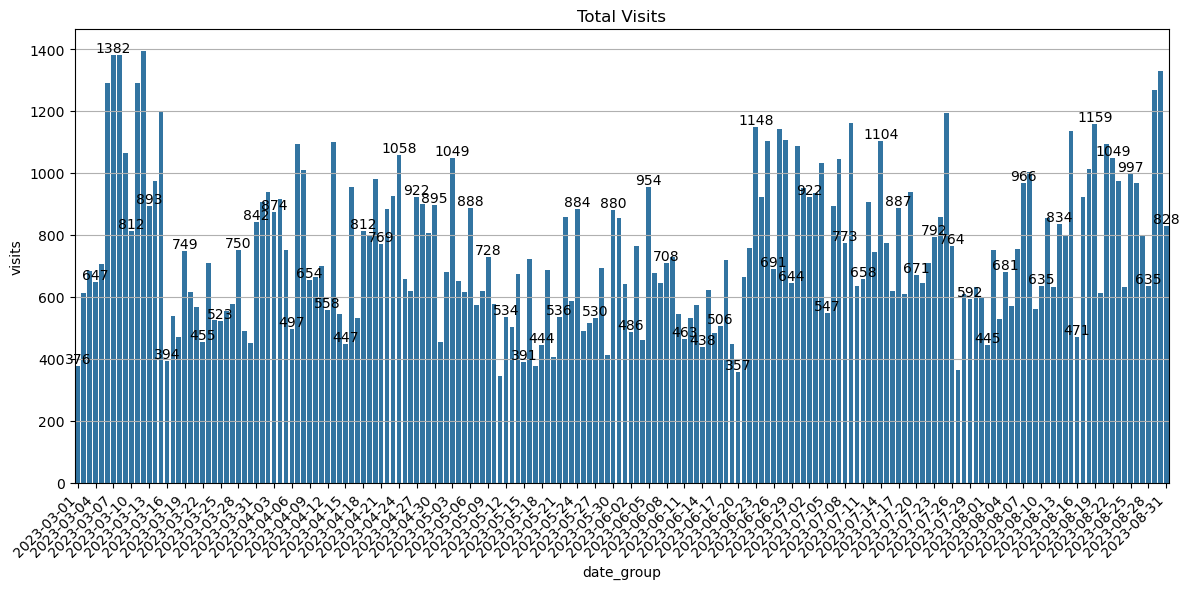

In [40]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='date_group', y='visits', data=total_visits_by_date, errorbar=None)
plt.title('Total Visits')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.xticks(rotation=45)
plt.grid(True) # Add grid
plt.grid(axis='x')

tick_positions = plt.gca().get_xticks()

for container in ax.containers:
    for j, bar in enumerate(container.patches):
        if j % scale == 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

plt.xticks(tick_indices, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f'./charts/total_visits.png')
plt.show()

2. Итоговые визиты с разбивкой по платформам

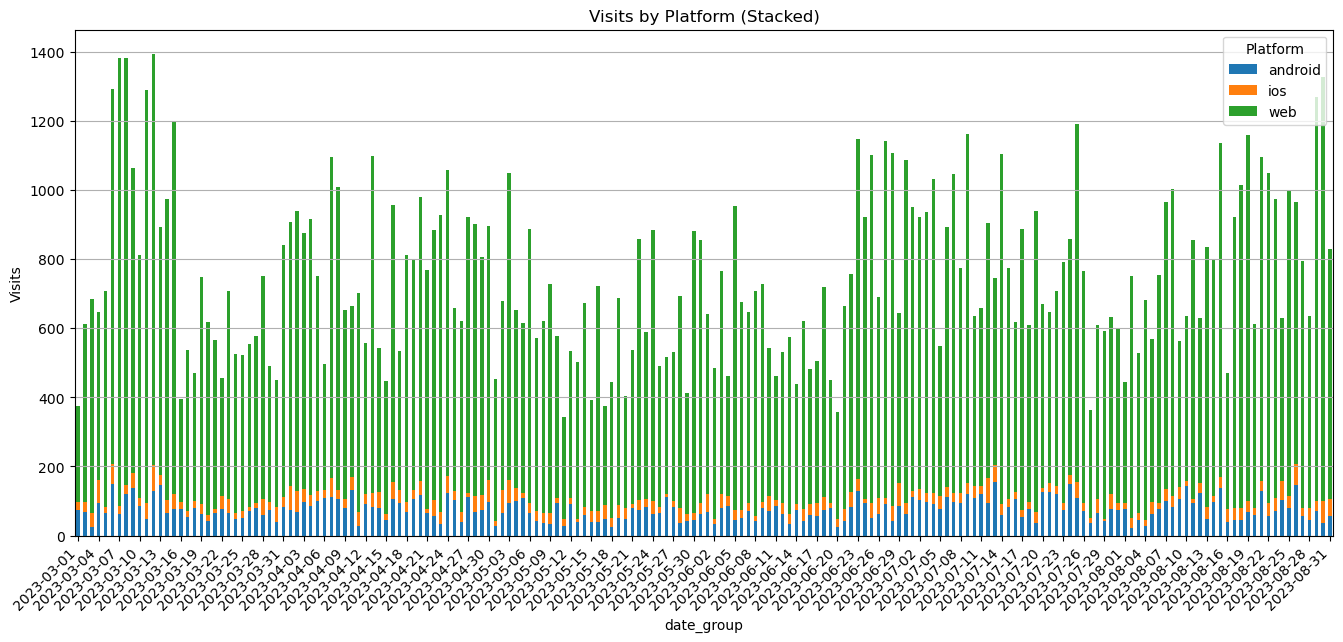

In [41]:
plt.figure(figsize=(14, 7))
ax = merged_data_sorted.pivot(index='date_group', columns='platform', values='visits').plot(kind='bar', stacked=True, figsize=(14, 7), ax=plt.gca())
plt.title('Visits by Platform (Stacked)')
plt.xlabel('date_group')
plt.ylabel('Visits')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.legend(title='Platform', loc='upper right')
plt.tight_layout()

num_dates = len(merged_data_sorted['date_group'].unique())
scale = max(1, num_dates // 60) 
tick_indices = range(0, num_dates, scale)

merged_data_sorted['date_group'] = pd.to_datetime(merged_data_sorted['date_group'])

unique_dates_str = merged_data_sorted['date_group'].dt.strftime('%Y-%m-%d').unique()
tick_labels = [unique_dates_str[i] for i in tick_indices]

plt.xticks(tick_indices, tick_labels, rotation=45, ha='right')
plt.savefig(f'./charts/total_visits_by_platform.png')
plt.show()

3. Итоговые регистрации

In [42]:
total_registrations_by_date = merged_data_sorted.groupby('date_group')['registrations'].sum().reset_index()

In [43]:
num_dates = len(total_registrations_by_date['date_group'])
scale = num_dates // 60
tick_indices = range(0, num_dates, scale)

dates_str = total_registrations_by_date['date_group'].dt.strftime('%Y-%m-%d')
tick_labels = [dates_str[i] for i in tick_indices]

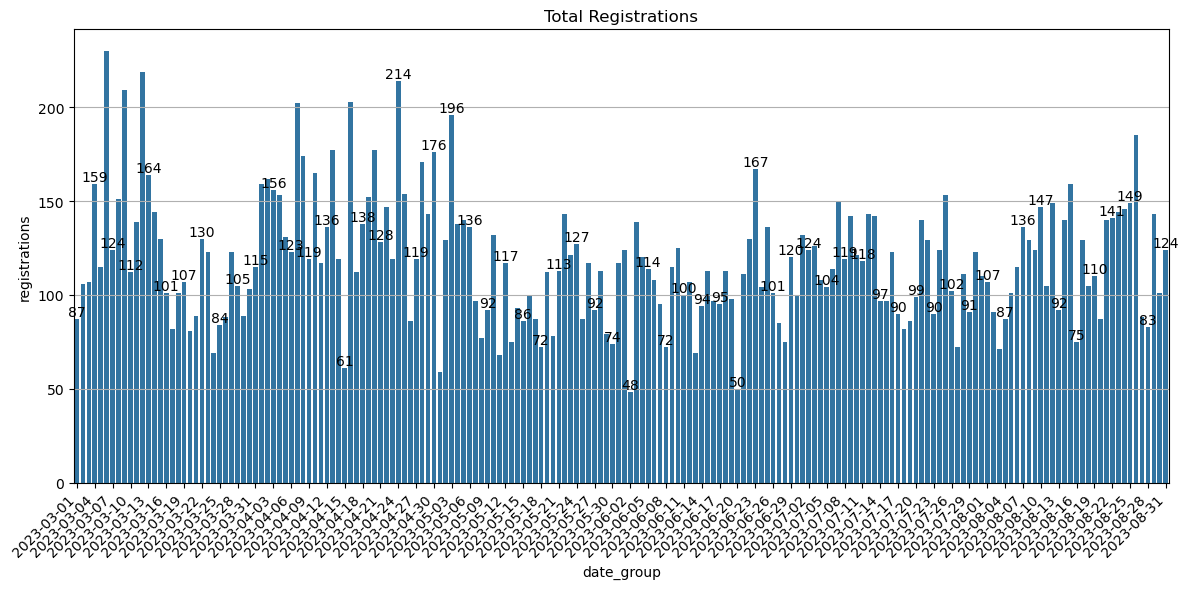

In [44]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='date_group', y='registrations', data=total_registrations_by_date, errorbar=None)
plt.title('Total Registrations')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.xticks(rotation=45)
plt.grid(True) 
plt.grid(axis='x')

tick_positions = plt.gca().get_xticks()

for container in ax.containers:
    for j, bar in enumerate(container.patches):
        if j % scale == 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    '%d' % int(height),
                    ha='center', va='bottom')

plt.xticks(tick_indices, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f'./charts/total_registrations.png')
plt.show()

4. Итоговые регистрации с разбивкой по платформам

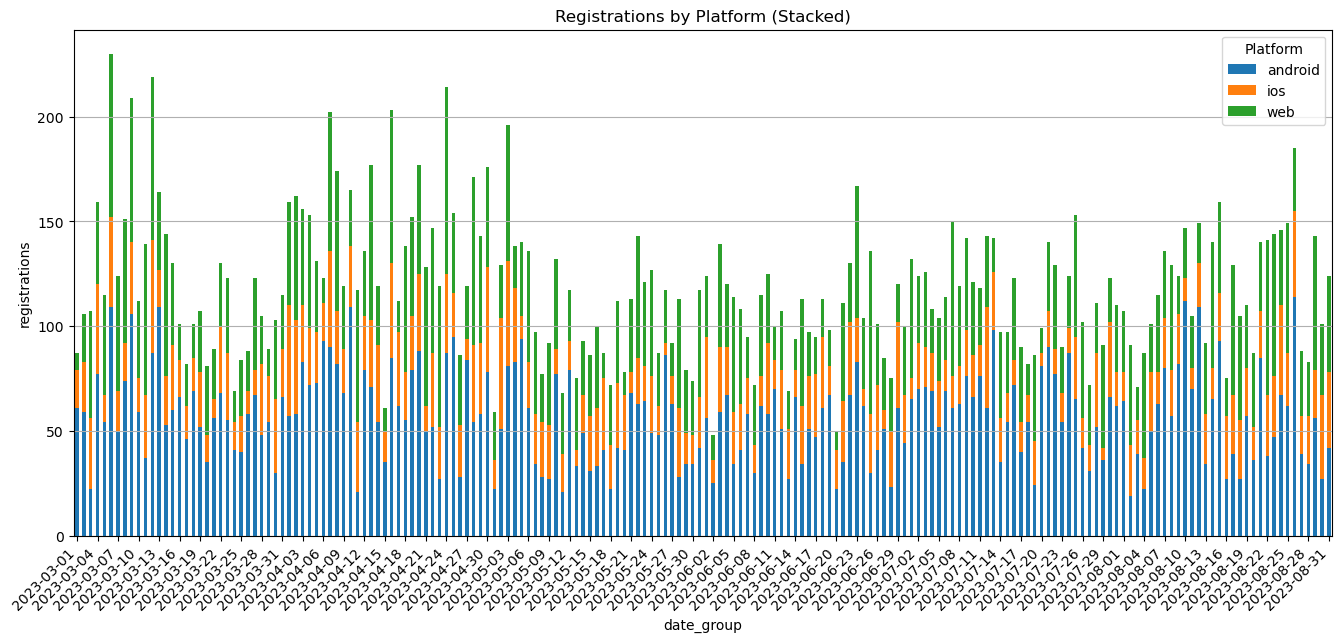

In [45]:
plt.figure(figsize=(14, 7))
ax = merged_data_sorted.pivot(index='date_group', columns='platform', values='registrations').plot(kind='bar', stacked=True, figsize=(14, 7), ax=plt.gca())
plt.title('Registrations by Platform (Stacked)')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.legend(title='Platform', loc='upper right')
plt.tight_layout()

num_dates = len(merged_data_sorted['date_group'].unique())
scale = max(1, num_dates // 60)
tick_indices = range(0, num_dates, scale)

merged_data_sorted['date_group'] = pd.to_datetime(merged_data_sorted['date_group'])

unique_dates_str = merged_data_sorted['date_group'].dt.strftime('%Y-%m-%d').unique()
tick_labels = [unique_dates_str[i] for i in tick_indices]

plt.xticks(tick_indices, tick_labels, rotation=45, ha='right')
plt.savefig(f'./charts/total_registrations_by_platform.png')
plt.show()

5. Итоговая конверсия

In [46]:
total_conversions = merged_data_sorted.groupby('date_group')[['visits', 'registrations']].sum().reset_index()

In [47]:
total_conversions["conversion"] = (total_conversions["visits"] / total_conversions["registrations"]).round(2)

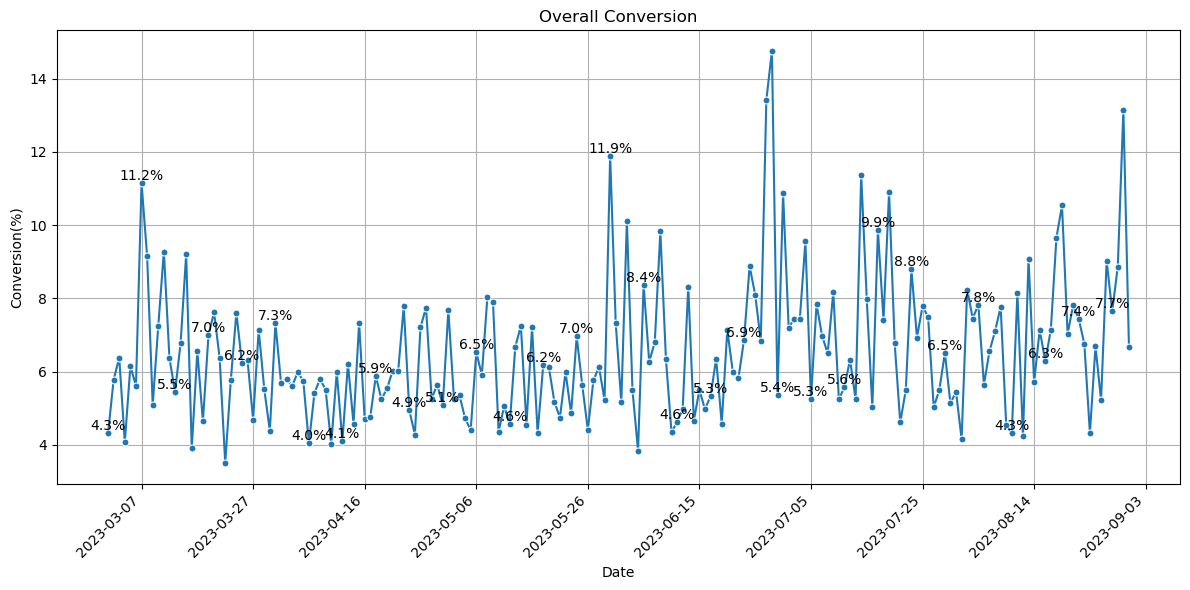

In [48]:
total_conversions['date_group'] = pd.to_datetime(total_conversions['date_group'])

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='date_group', y='conversion', data=total_conversions, marker='o', markersize=5)
plt.title('Overall Conversion')
plt.xlabel('Date')
plt.ylabel('Conversion(%)')
plt.grid(True)

num_dates = len(total_conversions['date_group'].unique())
interval = max(1, num_dates // 9)


ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

label_interval = max(1, num_dates // 30)
for i in range(0, num_dates, label_interval):
    date = total_conversions['date_group'].iloc[i]
    conversion = total_conversions['conversion'].iloc[i]
    ax.text(date, conversion, f'{conversion:.1f}%', ha='center', va='bottom')


plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'./charts/total_conversion.png')
plt.show()

6. Конверсия по платформам

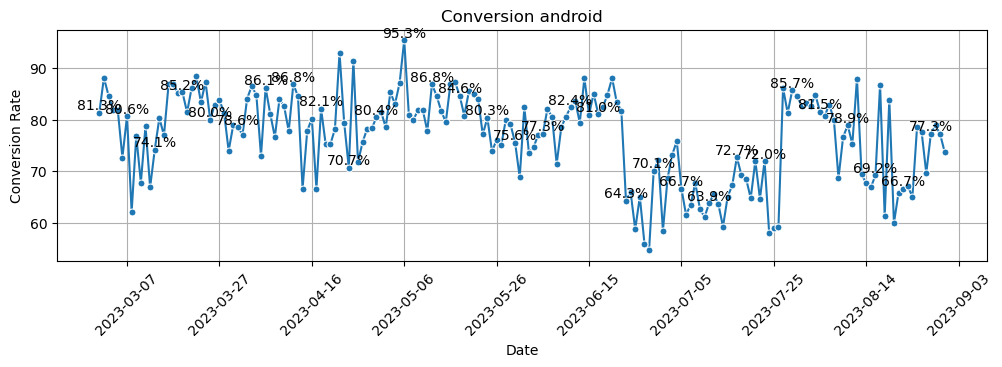

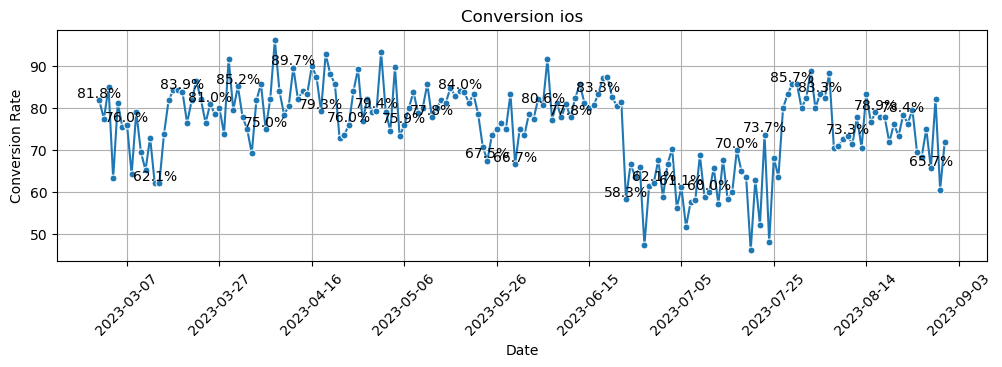

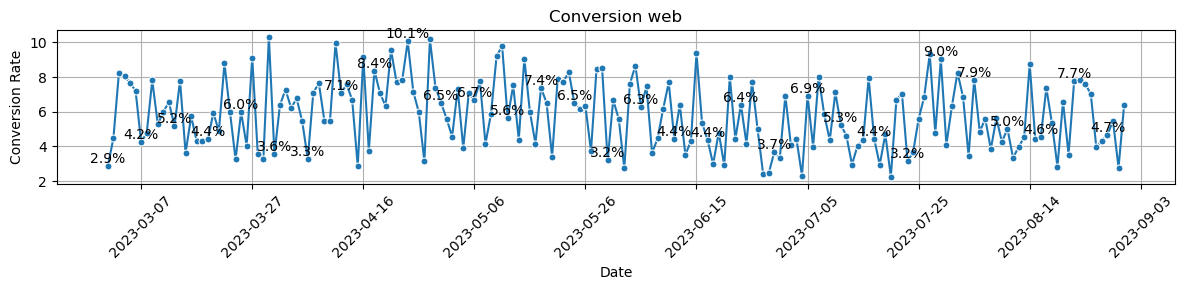

In [57]:
platforms = merged_data_sorted['platform'].unique()

for platform in platforms:
    plt.figure(figsize=(12, 3))
    platform_data = merged_data_sorted[merged_data_sorted['platform'] == platform]
    ax = sns.lineplot(x='date_group', y='conversion', data=platform_data, marker='o', markersize=5)
    plt.title(f'Conversion {platform}')
    plt.xlabel('Date')
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45)
    plt.grid(True)

    num_dates = len(platform_data['date_group'].unique())
    interval = max(1, num_dates // 9)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    label_interval = max(1, num_dates // 30)
    for i in range(0, num_dates, label_interval):
      date = platform_data['date_group'].iloc[i]
      conversion = platform_data['conversion'].iloc[i]
      ax.text(date, conversion, f'{conversion:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./charts/'+platform+'_total_conversion_by_platform.png')
plt.show()

7. Стоимости реклам

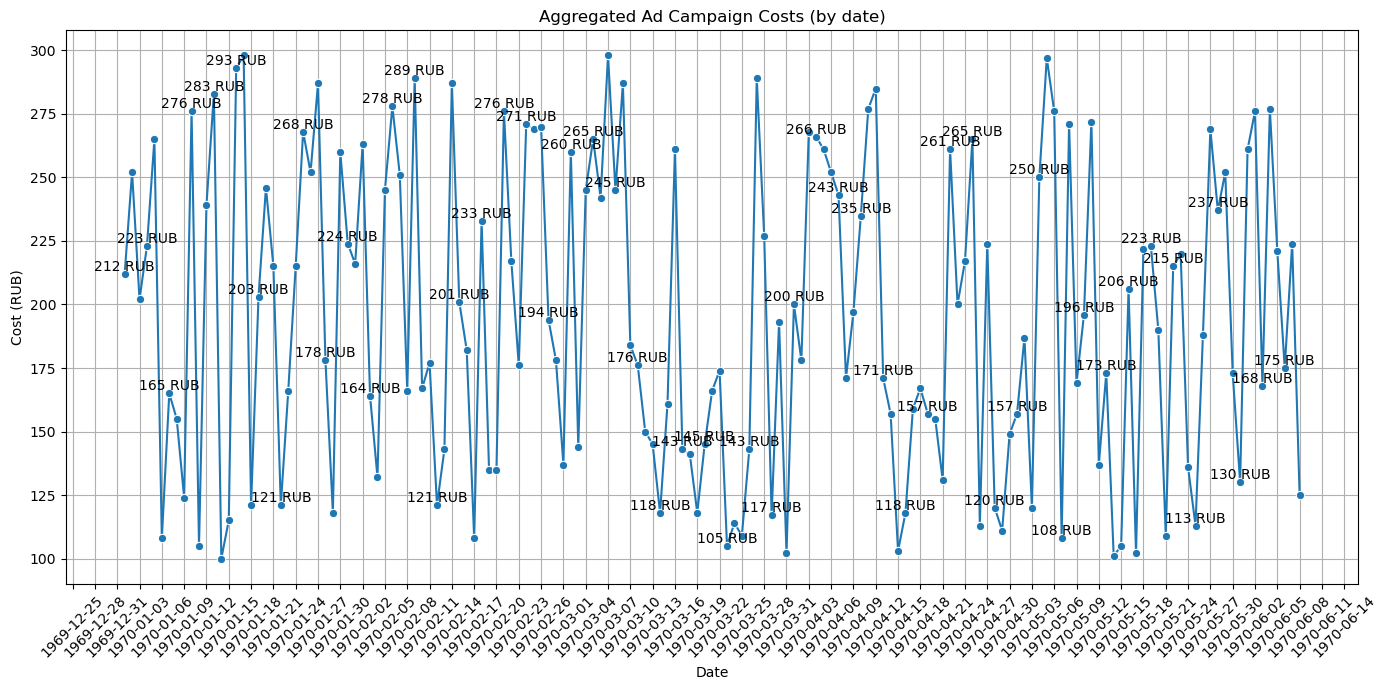

In [56]:
total_cost_by_date = df_ads_sorted.groupby('date')['cost'].sum().reset_index()

plt.figure(figsize=(14, 7))
ax = sns.lineplot(x='date', y='cost', data=total_cost_by_date, marker='o')
plt.title('Aggregated Ad Campaign Costs (by date)')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.xticks(rotation=45)
plt.grid(True)

num_dates = len(total_cost_by_date['date'].unique())
interval = max(1, num_dates // 50)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
for i in range(0, num_dates, interval):
  date = total_cost_by_date['date'].iloc[i]
  cost = total_cost_by_date['cost'].iloc[i]
  ax.text(date, cost, f'{cost:.0f} RUB', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'./charts/campaigns_cost_by_date.png')
plt.show()

8. Визиты и регистрации с выделением рекламных кампаний

In [ ]:
totals_by_date = merged_data_sorted.groupby('date_group')[['visits', 'registrations']].sum().reset_index()

In [ ]:
merged_df_sorted.head(10)

In [ ]:
campaign_dates = merged_df_sorted.groupby('utm_campaign')['date_group'].agg(['min', 'max']).reset_index()
campaign_dates = campaign_dates.rename(columns={'min': 'start_date', 'max': 'end_date'})
campaign_dates['start_date'] = pd.to_datetime(campaign_dates['start_date'])
campaign_dates['end_date'] = pd.to_datetime(campaign_dates['end_date'])
campaign_dates = campaign_dates.sort_values(by='start_date')
campaign_dates

In [ ]:
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x='date_group', y='visits', data=totals_by_date, marker='o', label='Visits')
plt.title('Visits during marketing active days')
plt.xlabel('Date')
plt.ylabel('Unique visits')
plt.xticks(rotation=45)
plt.grid(True)

average_visits = totals_by_date['visits'].mean()
plt.axhline(average_visits, color='grey', linestyle='--', label=f'Average Visits: {average_visits:.2f}')

num_dates = len(totals_by_date['date_group'])
interval = max(1, num_dates // 9)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

colors = sns.color_palette("husl")

for i, row in campaign_dates.iterrows():
    if row['utm_campaign'] != 'none':
        ax.axvspan(row['start_date'], row['end_date'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'./charts/visits_by_campaigns.png')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x='date_group', y='registrations', data=totals_by_date, marker='o', label='Visits')
plt.title('Registrations during marketing active days')
plt.xlabel('Date')
plt.ylabel('Unique registrations')
plt.xticks(rotation=45)
plt.grid(True)

average_visits = totals_by_date['registrations'].mean()
plt.axhline(average_visits, color='grey', linestyle='--', label=f'Average Visits: {average_visits:.2f}')

num_dates = len(totals_by_date['date_group'])
interval = max(1, num_dates // 9)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

colors = sns.color_palette("husl")

for i, row in campaign_dates.iterrows():
    if row['utm_campaign'] != 'none':
        ax.axvspan(row['start_date'], row['end_date'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'./charts/registrations_by_campaigns.png')
plt.show()